# Análisis descriptivo y EDA

###  1. Descripción general del dataset y evaluación de datos faltantes

In [2]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
current_dir = os.getcwd()
import matplotlib.pyplot as plt
import seaborn as sns

Se carga el dataframe. Nuestro objetivo es predecir la demanda (sales), por lo que se trata de un problema de regresión.

In [3]:
final_xgboost_data_path = os.path.join(current_dir, "../data/raw/Final_XGBoost_data_processed.csv")
data = pd.read_csv(final_xgboost_data_path)

In [4]:
data.head(5)

,item_id,store_id,month,sales,event_name_1,snap_CA,snap_TX,snap_WI,sell_price,snap,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,FOODS_1_012,CA_2,2012-01-01,0,1,1,1,0,6.08000,1,0.0,0.0,0.0,11.0,0.0,0.0,2012,True,False,False,False,False,False,False,False,False,False,False,False
1,FOODS_1_012,CA_2,2012-02-01,0,1,1,1,0,6.08000,1,0.0,0.0,0.0,21.0,0.0,0.0,2012,False,True,False,False,False,False,False,False,False,False,False,False
2,FOODS_1_012,CA_2,2012-03-01,0,1,1,1,0,6.08000,1,0.0,0.0,0.0,0.0,0.0,0.0,2012,False,False,True,False,False,False,False,False,False,False,False,False
3,FOODS_1_012,CA_2,2012-04-01,0,1,1,1,0,6.08000,1,0.0,0.0,0.0,0.0,0.0,0.0,2012,False,False,False,True,False,False,False,False,False,False,False,False
4,FOODS_1_012,CA_2,2012-05-01,60,1,1,1,0,5.90675,1,0.0,0.0,0.0,0.0,0.0,0.0,2012,False,False,False,False,True,False,False,False,False,False,False,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10600 entries, 0 to 10599
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         10600 non-null  object 
 1   store_id        10600 non-null  object 
 2   month           10600 non-null  object 
 3   sales           10600 non-null  int64  
 4   event_name_1    10600 non-null  int64  
 5   snap_CA         10600 non-null  int64  
 6   snap_TX         10600 non-null  int64  
 7   snap_WI         10600 non-null  int64  
 8   sell_price      10600 non-null  float64
 9   snap            10600 non-null  int64  
 10  lag_1           10600 non-null  float64
 11  lag_2           10600 non-null  float64
 12  lag_3           10600 non-null  float64
 13  lag_6           10600 non-null  float64
 14  lag_12          10600 non-null  float64
 15  rolling_mean_3  10600 non-null  float64
 16  year            10600 non-null  int64  
 17  month_1         10600 non-null 

Se comprueban valores nulos

In [6]:
isna_sum = data.isna().sum()

isna_sum.sort_values(ascending = False)

item_id           0
store_id          0
month             0
sales             0
event_name_1      0
snap_CA           0
snap_TX           0
snap_WI           0
sell_price        0
snap              0
lag_1             0
lag_2             0
lag_3             0
lag_6             0
lag_12            0
rolling_mean_3    0
year              0
month_1           0
month_2           0
month_3           0
month_4           0
month_5           0
month_6           0
month_7           0
month_8           0
month_9           0
month_10          0
month_11          0
month_12          0
dtype: int64

In [7]:
data.columns

Index(['item_id', 'store_id', 'month', 'sales', 'event_name_1', 'snap_CA',
       'snap_TX', 'snap_WI', 'sell_price', 'snap', 'lag_1', 'lag_2', 'lag_3',
       'lag_6', 'lag_12', 'rolling_mean_3', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

`item_id`: Identificador único del producto o artículo.

`store_id`: Identificador único de la tienda donde se vendió el producto.

`month`: Fecha mensual en formato de periodo de tiempo.

`sales`: Total de unidades vendidas del producto en la tienda en ese mes.

`event_name_1`: Nombre del evento especial asociado a ese día/mes, como un feriado o promoción. Puede ser nulo si no hubo evento.

`snap_CA`: Indican si un día está cubierto por el programa SNAP en California.

`snap_TX`: Indican si un día está cubierto por el programa SNAP en Texas.

`snap_WI`: Indican si un día está cubierto por el programa SNAP en Wisconsin.

`sell_price`: Precio promedio al que se vendió el producto en ese mes.

`snap`: Esta columna representa si el día o mes tiene un beneficio del programa SNAP (Supplemental Nutrition Assistance Program) activo.

`lag_1, lag_2, lag_3, lag_6, lag_12`: Estas columnas son características de retraso (lag features) que representan las ventas del mismo producto en la misma tienda, pero con un desfase anterior de 1 mes, 2 meses, 3 meses, 6 meses y 12 meses. Ayudan al modelo a capturar patrones históricos y estacionalidades.

`rolling_mean_3`: Es el promedio móvil de ventas de los últimos 3 meses, excluyendo el mes actual. Útil para detectar tendencias suaves a corto plazo.

`month_1 a month_12`: Estas columnas son variables one-hot encoded para representar el mes en que ocurre la venta. Permiten al modelo capturar la estacionalidad mensual, como picos de ventas en diciembre o caídas en enero, etc.



 ### 2. Estadísticas descriptivas básicas
 Se obtienen valores de media, mediana, moda, desviación estándar, rango, percentiles, cuartiles y la distribución

In [8]:
data.describe()

,sales,event_name_1,snap_CA,snap_TX,snap_WI,sell_price,snap,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,year
count,10600.000000,10600.000000,10600.0,10600.0,10600.0,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000
mean,692.175660,0.962264,1.0,1.0,0.0,1.608005,0.700000,697.322736,698.533019,700.308302,699.860755,670.847453,698.721352,2013.735849
std,624.023876,0.190566,0.0,0.0,0.0,1.011744,0.458279,635.758060,642.589797,651.082129,658.105513,660.663182,610.286747,1.290826
min,0.000000,0.000000,1.0,1.0,0.0,0.156667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000
25%,326.000000,1.000000,1.0,1.0,0.0,1.000000,0.000000,327.000000,326.000000,324.750000,319.000000,287.750000,341.583333,2013.000000
50%,535.000000,1.000000,1.0,1.0,0.0,1.480000,1.000000,538.000000,537.000000,536.000000,535.000000,513.000000,532.666667,2014.000000
75%,876.000000,1.000000,1.0,1.0,0.0,1.680000,1.000000,881.000000,881.000000,883.000000,885.250000,866.000000,866.333333,2015.000000
max,10821.000000,1.000000,1.0,1.0,0.0,6.980000,1.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,8404.000000,2016.000000


Estadísticas descriptivas para variables numéricas

In [9]:
# Seleccionar solo columnas numéricas
numericas = data.select_dtypes(include='number').columns

# Calcular estadísticas descriptivas
estadisticas_numericas = data[numericas].describe(percentiles=[0.25, 0.5, 0.75]).T
estadisticas_numericas = estadisticas_numericas.rename(columns={
    "25%": "Q1",
    "50%": "Mediana",
    "75%": "Q3",
    "std": "Desviación estándar",
    "mean": "Media",
    "min": "Mínimo",
    "max": "Máximo"
})
estadisticas_numericas = estadisticas_numericas[["count", "Media", "Mediana", "Desviación estándar", "Mínimo", "Q1", "Q3", "Máximo"]]


In [10]:
print("Estadísticas descriptivas para variables numéricas:\n")
print(estadisticas_numericas)

Estadísticas descriptivas para variables numéricas:

                  count        Media      Mediana  Desviación estándar  \
sales           10600.0   692.175660   535.000000           624.023876   
event_name_1    10600.0     0.962264     1.000000             0.190566   
snap_CA         10600.0     1.000000     1.000000             0.000000   
snap_TX         10600.0     1.000000     1.000000             0.000000   
snap_WI         10600.0     0.000000     0.000000             0.000000   
sell_price      10600.0     1.608005     1.480000             1.011744   
snap            10600.0     0.700000     1.000000             0.458279   
lag_1           10600.0   697.322736   538.000000           635.758060   
lag_2           10600.0   698.533019   537.000000           642.589797   
lag_3           10600.0   700.308302   536.000000           651.082129   
lag_6           10600.0   699.860755   535.000000           658.105513   
lag_12          10600.0   670.847453   513.000000          

Estadísticas descriptivas para variables categóricas

In [11]:
categoricas = ['event_name_1', 'snap_CA', 'snap_TX', 'snap_WI']
# Para cada variable categórica
for col in categoricas:
    print(f"\nAnálisis de la variable: {col}")
    # Frecuencia absoluta
    frec_abs = data[col].value_counts()
    # Frecuencia relativa (%)
    frec_rel = data[col].value_counts(normalize=True) * 100
    # Combinar en un DataFrame
    tabla = pd.DataFrame({
        'Frecuencia Absoluta': frec_abs,
        'Frecuencia Relativa (%)': frec_rel.round(2)
    })
    print(tabla)
    # Conteo de clases
    print(f"Número de clases (categorías únicas) en '{col}': {data[col].nunique()}")


Análisis de la variable: event_name_1
              Frecuencia Absoluta  Frecuencia Relativa (%)
event_name_1                                              
1                           10200                    96.23
0                             400                     3.77
Número de clases (categorías únicas) en 'event_name_1': 2

Análisis de la variable: snap_CA
         Frecuencia Absoluta  Frecuencia Relativa (%)
snap_CA                                              
1                      10600                    100.0
Número de clases (categorías únicas) en 'snap_CA': 1

Análisis de la variable: snap_TX
         Frecuencia Absoluta  Frecuencia Relativa (%)
snap_TX                                              
1                      10600                    100.0
Número de clases (categorías únicas) en 'snap_TX': 1

Análisis de la variable: snap_WI
         Frecuencia Absoluta  Frecuencia Relativa (%)
snap_WI                                              
0                      1060

Observamos que snap_CA, snap_TX y snap_WI presentan un valor único, lo que puede presentar problemas futuros al tratar de representarlos.

C:\Users\andta\AppData\Local\Temp\ipykernel_31784\3215840923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=col, order=orden, palette="pastel")


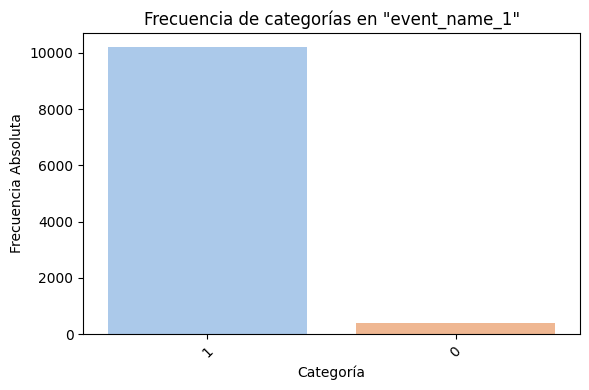

C:\Users\andta\AppData\Local\Temp\ipykernel_31784\3215840923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=col, order=orden, palette="pastel")


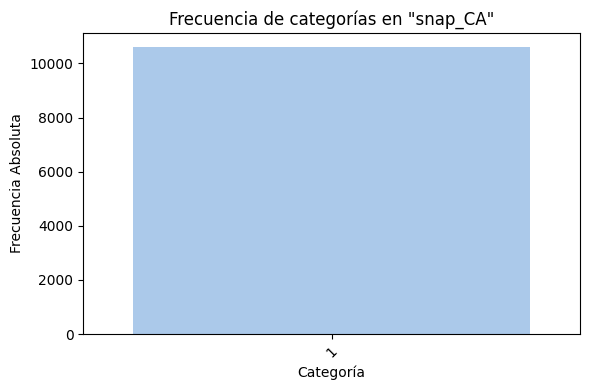

C:\Users\andta\AppData\Local\Temp\ipykernel_31784\3215840923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=col, order=orden, palette="pastel")


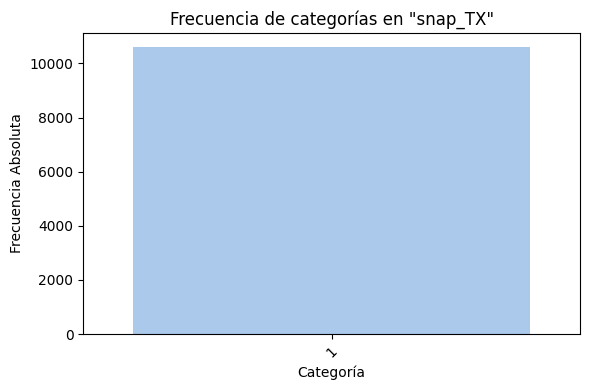

C:\Users\andta\AppData\Local\Temp\ipykernel_31784\3215840923.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x=col, order=orden, palette="pastel")


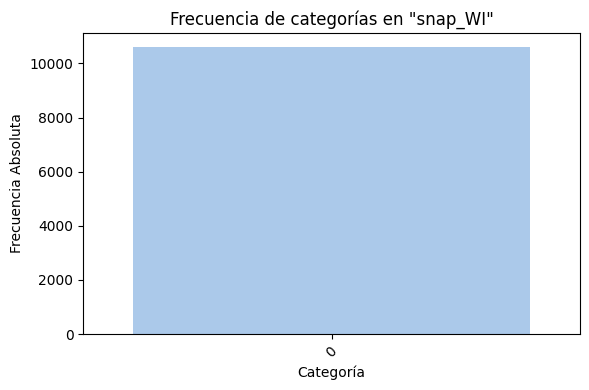

In [12]:
for col in categoricas:
    plt.figure(figsize=(6,4))
    orden = data[col].value_counts().index
    ax = sns.countplot(data=data, x=col, order=orden, palette="pastel")
    plt.title(f'Frecuencia de categorías en "{col}"')
    plt.ylabel('Frecuencia Absoluta')
    plt.xlabel('Categoría')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 3. Análisis descriptivo por columna

In [13]:
data.columns

Index(['item_id', 'store_id', 'month', 'sales', 'event_name_1', 'snap_CA',
       'snap_TX', 'snap_WI', 'sell_price', 'snap', 'lag_1', 'lag_2', 'lag_3',
       'lag_6', 'lag_12', 'rolling_mean_3', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

#### Sales

In [14]:
print(data.sales.describe())
print(f'Median: {data.sales.median()}')
print(f'Mode: {data.sales.mode()[0]}') # He puesto el [0] para mostrar solo el valor de la moda porque si no aparece con el indice.  
range_ = max(data.sales) - min(data.sales)
print(f"Rango: {range_}")

count    10600.000000
mean       692.175660
std        624.023876
min          0.000000
25%        326.000000
50%        535.000000
75%        876.000000
max      10821.000000
Name: sales, dtype: float64
Median: 535.0
Mode: 0
Rango: 10821


- Comprobamos los valores únicos que tenemos de productos

In [15]:
data['item_id'].nunique()

66

- En la columna sales vemos que de media sale 692.17 productos y un máximo de 10821. 

- Moda: vemos que el valor más repetidos del subconjunto seleccionado para las ventas por producto es 0.

- Mediana: vemos que el valor central del conjunto de datos es 535.

Se comprueba si hay valores nulos:

In [16]:
print(data.sales.isnull().sum())

0


Se comprueba los valores únicos:

In [17]:
print(data.sales.nunique())

2077


In [18]:
data.sales.dtype

dtype('int64')

- Distribución: Se observa que sigue una distribución normal sesgada a la izquierda.

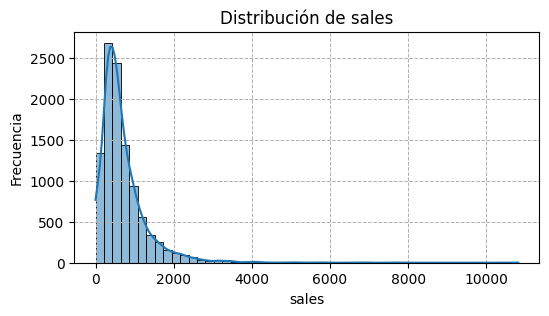

In [19]:
plt.figure(figsize=(6,3))
sns.histplot(data['sales'], kde=True, bins=50)
plt.title('Distribución de sales')
plt.xlabel('sales')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()

##### Tendencias a lo largo del tiempo

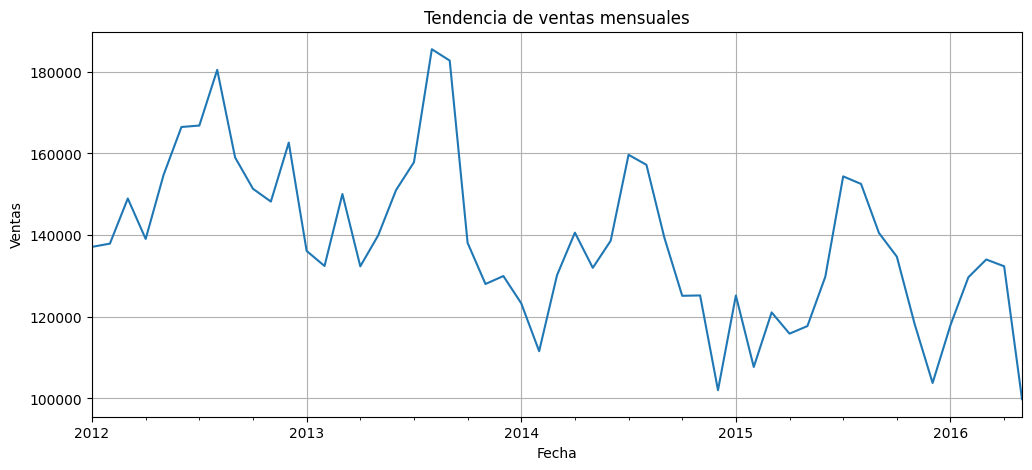

In [20]:
# Asegúrate de que la columna de fechas sea tipo datetime
data['month'] = pd.to_datetime(data['month'])

# Agrupar por fecha (mes) y sumar ventas
ventas_mensuales = data.groupby('month')['sales'].sum()

# Graficar la serie temporal
plt.figure(figsize=(12, 5))
ventas_mensuales.plot()
plt.title("Tendencia de ventas mensuales")
plt.ylabel("Ventas")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

##### Estacionalidad y ciclos 

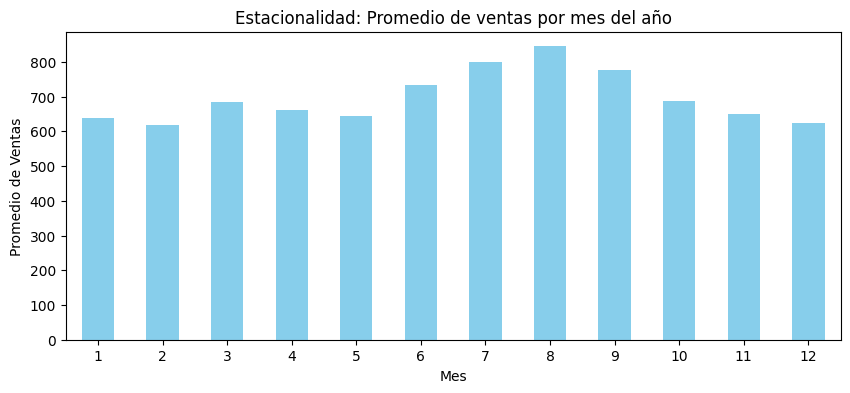

In [21]:
# Extraer mes y año
data['año'] = data['month'].dt.year
data['mes'] = data['month'].dt.month

# Promedio de ventas por mes del año (para detectar estacionalidad)
ventas_estacionales = data.groupby('mes')['sales'].mean()

plt.figure(figsize=(10, 4))
ventas_estacionales.plot(kind='bar', color='skyblue')
plt.title("Estacionalidad: Promedio de ventas por mes del año")
plt.ylabel("Promedio de Ventas")
plt.xlabel("Mes")
plt.xticks(rotation=0)
plt.show()


Se observa que los meses en los que se producen más ventas son los meses 7,8 y 9 (Julio, Agosto, Septiembre). Por lo que existe un patrón de aumento de ventas en dichas fechas.

##### Comparación interanual

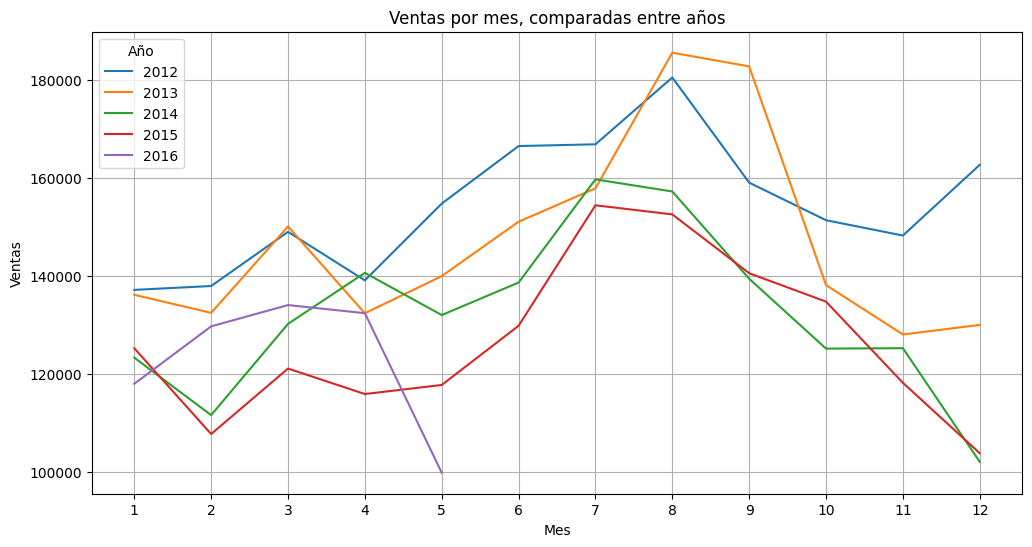

In [22]:
ventas_interanual = data.groupby(['año', 'mes'])['sales'].sum().unstack(level=0)

ventas_interanual.plot(figsize=(12, 6))
plt.title("Ventas por mes, comparadas entre años")
plt.ylabel("Ventas")
plt.xlabel("Mes")
plt.xticks(range(1, 13))
plt.legend(title="Año")
plt.grid(True)
plt.show()


Se observa que los años 2012 y 2013 es en los que se produce mayor número de ventas.

##### Visualización de dispersión entre sales y lag_i

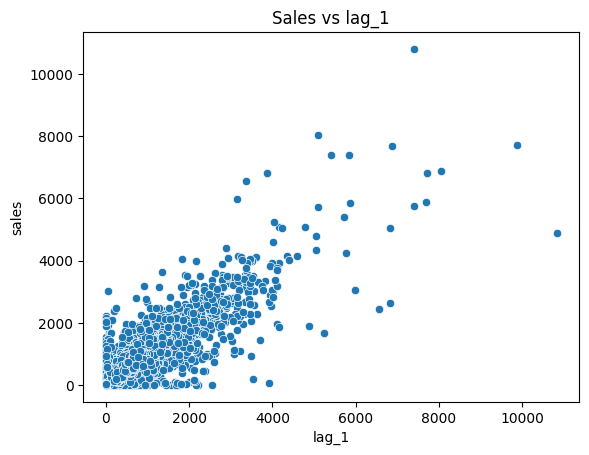

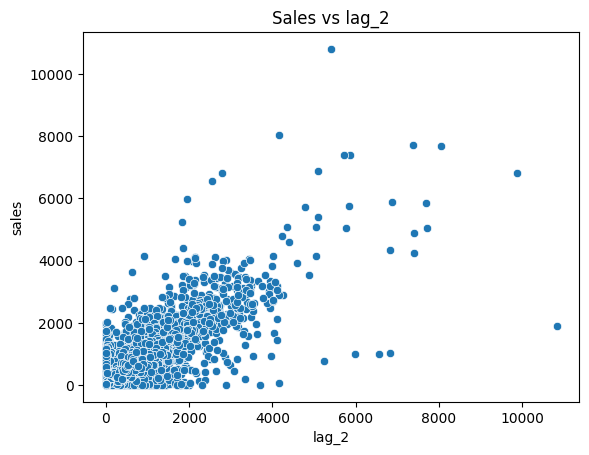

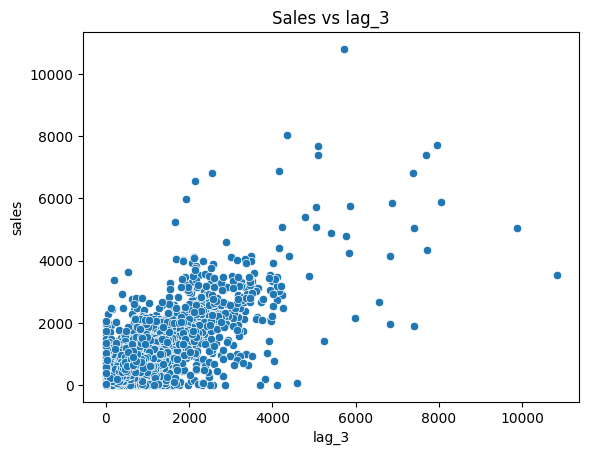

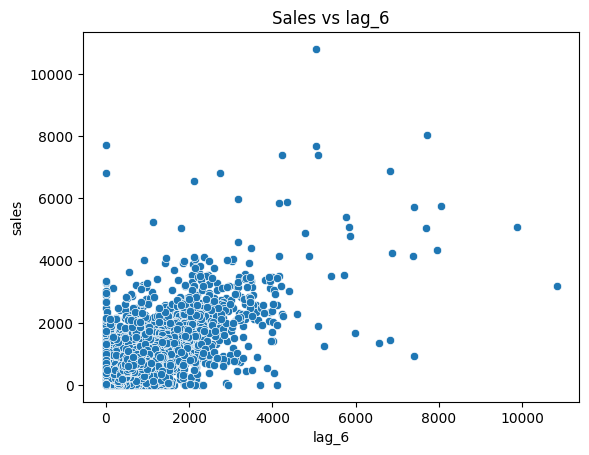

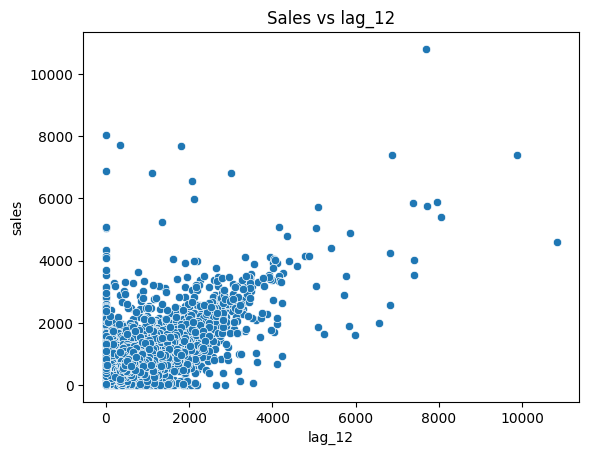

In [23]:

lag_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']

for col in lag_cols:
    sns.scatterplot(data=data, x=col, y='sales')
    plt.title(f'Sales vs {col}')
    plt.show()

#### Sell_price

In [25]:
print(data.sell_price.describe())
print(f'Median: {data.sell_price.median()}')
print(f'Mode: {data.sell_price.mode()[0]}') # He puesto el [0] para mostrar solo el valor de la moda porque si no aparece con el indice.  
range_ = max(data.sell_price) - min(data.sell_price)
print(f"Rango: {range_}")

count    10600.000000
mean         1.608005
std          1.011744
min          0.156667
25%          1.000000
50%          1.480000
75%          1.680000
max          6.980000
Name: sell_price, dtype: float64
Median: 1.48
Mode: 1.58
Rango: 6.823333333333335


Se comprueba si hay valores nulos:

In [26]:
print(data.sell_price.isnull().sum())

0


Se comprueba los valores únicos:

In [27]:
print(data.sell_price.nunique())

447


In [28]:
data.sell_price.dtype

dtype('float64')

- Distribución

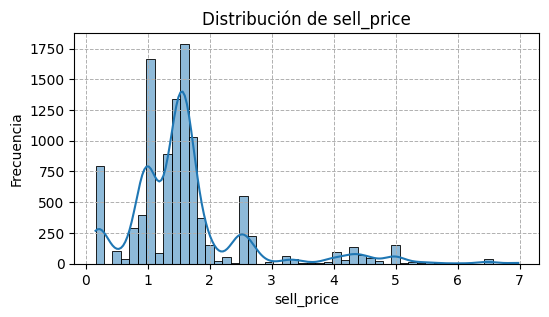

In [29]:
plt.figure(figsize=(6,3))
sns.histplot(data['sell_price'], kde=True, bins=50)
plt.title('Distribución de sell_price')
plt.xlabel('sell_price')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()

### Análisis de variables univariante

In [30]:
data.columns

Index(['item_id', 'store_id', 'month', 'sales', 'event_name_1', 'snap_CA',
       'snap_TX', 'snap_WI', 'sell_price', 'snap', 'lag_1', 'lag_2', 'lag_3',
       'lag_6', 'lag_12', 'rolling_mean_3', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'año', 'mes'],
      dtype='object')

#### Análisis sobre variables categóricas

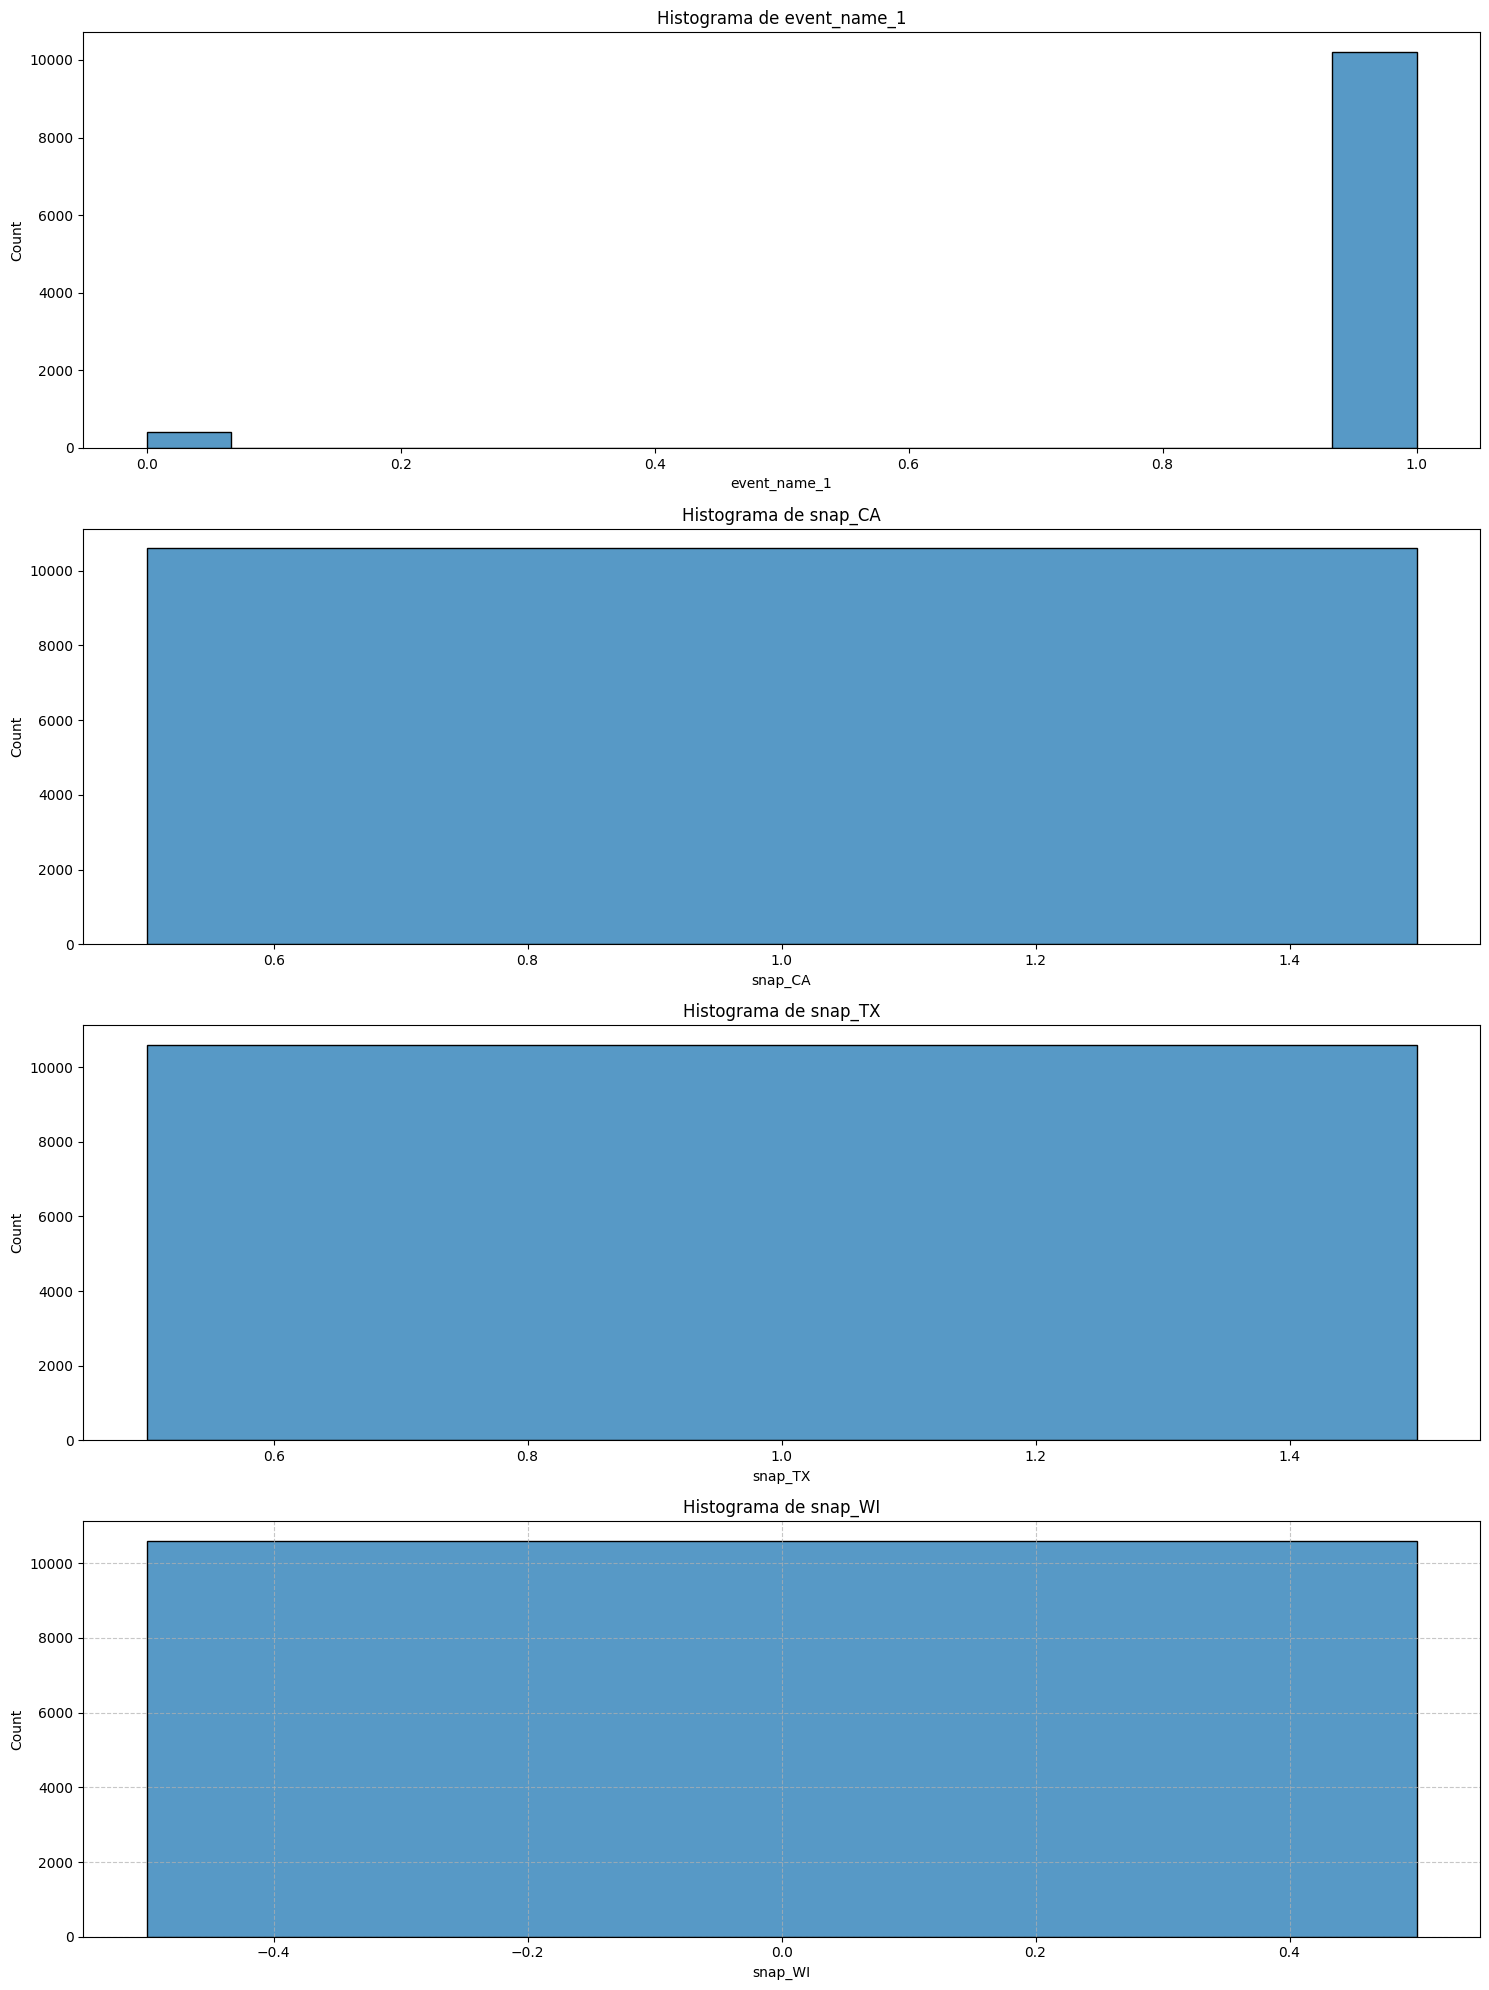

In [31]:
fig, axis = plt.subplots(len(categoricas), 1,figsize = (15, 5*len(categoricas)))

for i,col in enumerate(categoricas):
    # Crear un histograma múltiple
    sns.histplot( data = data, ax=axis[i], x = col)
    axis[i].set_title(f'Histograma de {col}')
    # grid
    plt.grid(linestyle="--", alpha=0.7)
    # Ajustar el layout
    plt.tight_layout()

# Mostrar el plot
plt.show()

#### Análisis sobre variables numéricas

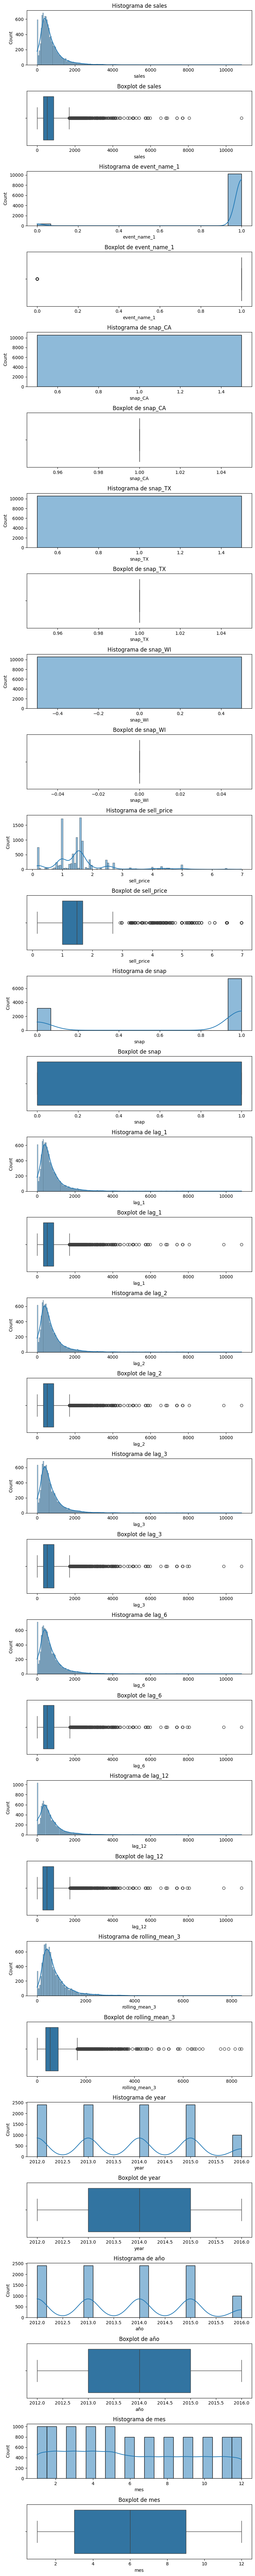

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
column_filter= data.select_dtypes(include='number').drop(columns=[''], errors='ignore').columns
# Crear la figura con 2 columnas y una fila por variable
fig, axes = plt.subplots(len(column_filter)*2, 1, figsize=(8, len(column_filter) * 5))

# Iterar sobre cada columna del DataFrame
for i, col in enumerate(column_filter):
    idx=i*2
    # Histograma en la primera fila
    sns.histplot(data=data, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Histograma de {col}')
    # Boxplot en la segunda fila
    sns.boxplot(data=data, x=col, ax=axes[idx+1])
    axes[idx+1].set_title(f'Boxplot de {col}')
    

# Ajustar diseño
plt.tight_layout()
plt.show()

### Análisis de variables multivariante

#### Análisis numérico-numérico

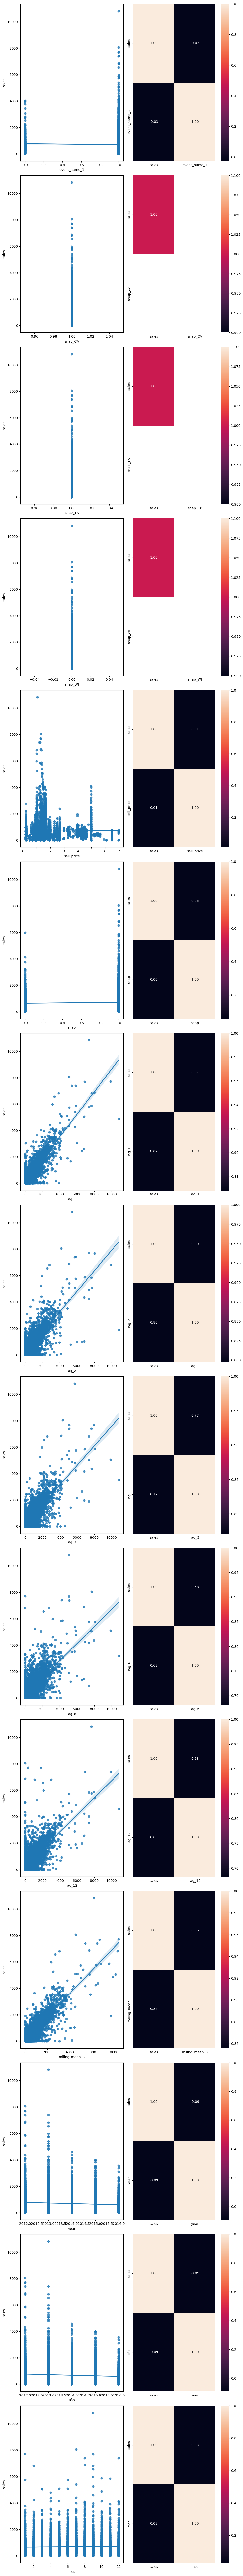

In [33]:
column_filter= data.select_dtypes(include='number').drop(columns=['sales'], errors='ignore').columns
fig, axis = plt.subplots(len(column_filter), 2, figsize = (10, 7*(len(column_filter))))

# Crear un diagrama de dispersión múltiple y la matriz de correlación entre las dos variables (predictora-target)
for i,col in enumerate(column_filter):
    sns.regplot(ax = axis[i, 0], data = data, x = col, y = 'sales')
    sns.heatmap(data[['sales', col]].corr(), annot = True, fmt = ".2f", ax = axis[i,1], cbar = True)

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

In [34]:
print(data[['snap_CA', 'snap_TX', 'snap_WI']].nunique())

snap_CA    1
snap_TX    1
snap_WI    1
dtype: int64


Comprobamos que 'snap_CA', 'snap_TX' y 'snap_WI' presentan un único valor, por lo que al realizar la matriz de correlación, su desviación estándar es 0. Eso causa que su correlación con otra variable sea indefinida o constante.

Además, se observa que los lags presentan una alta correlación con el target.

#### Análisis categórico-categórico

No se realiza debido a que nuestro target es numérico.

#### Análisis numérico-categórico

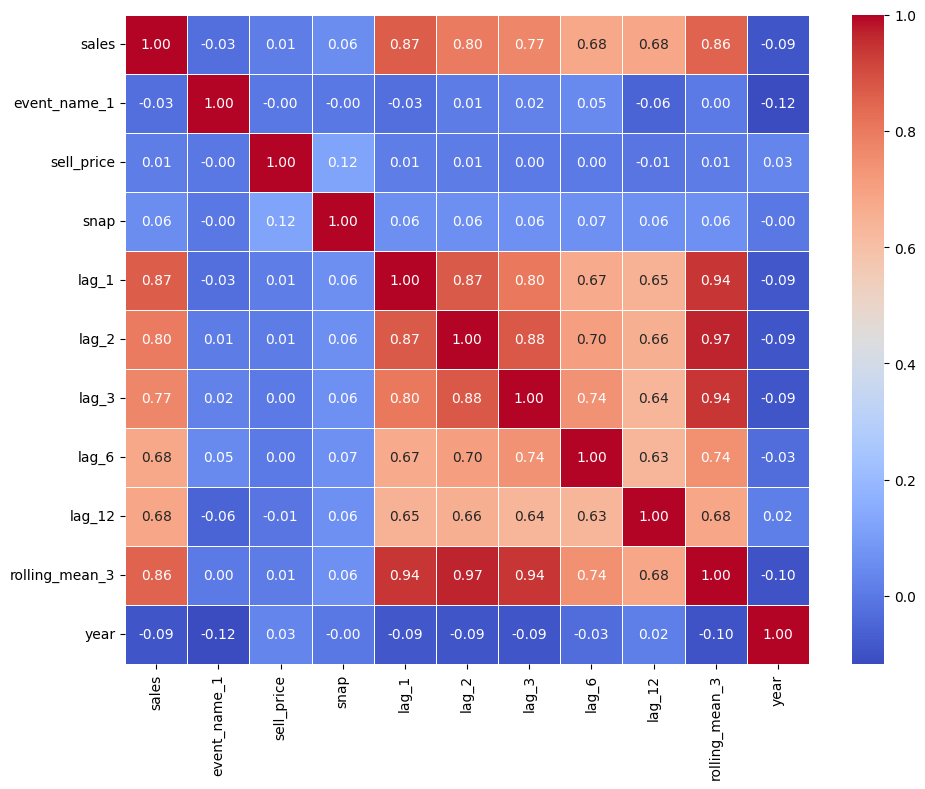

In [35]:
corr_matrix = data[['sales','event_name_1', 'sell_price', 'snap', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'year']].select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.tight_layout()

plt.show()

#### Correlación entre lags y rolling_mean y ventas actuales

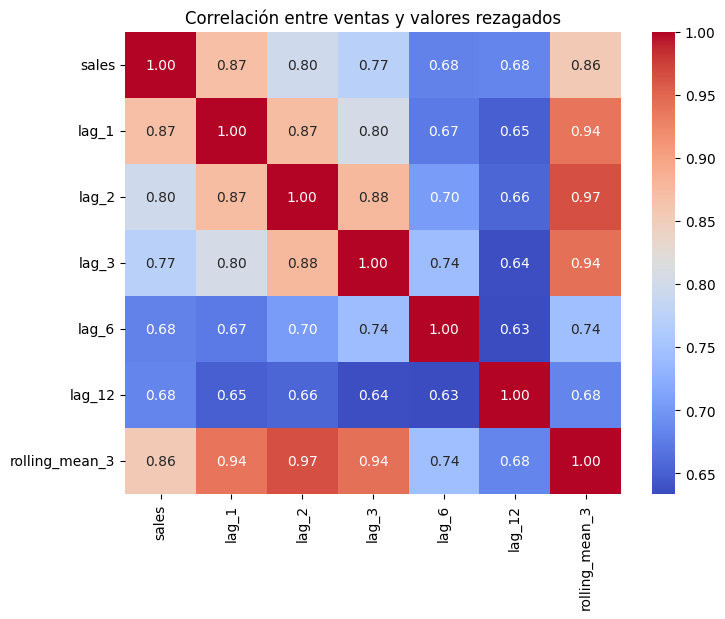

In [36]:

lag_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3']
df_lag_corr = data[['sales'] + lag_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(df_lag_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlación entre ventas y valores rezagados")
plt.show()


Como se ha podido comprobar previamente todos "lags" y "rolling mean" presentan una gran relación con nuestro target objetivo (sales).

### 5. Detección de valores atípicos

In [37]:
data.columns

Index(['item_id', 'store_id', 'month', 'sales', 'event_name_1', 'snap_CA',
       'snap_TX', 'snap_WI', 'sell_price', 'snap', 'lag_1', 'lag_2', 'lag_3',
       'lag_6', 'lag_12', 'rolling_mean_3', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'año', 'mes'],
      dtype='object')

In [38]:
columns_number = data.select_dtypes(include='number')

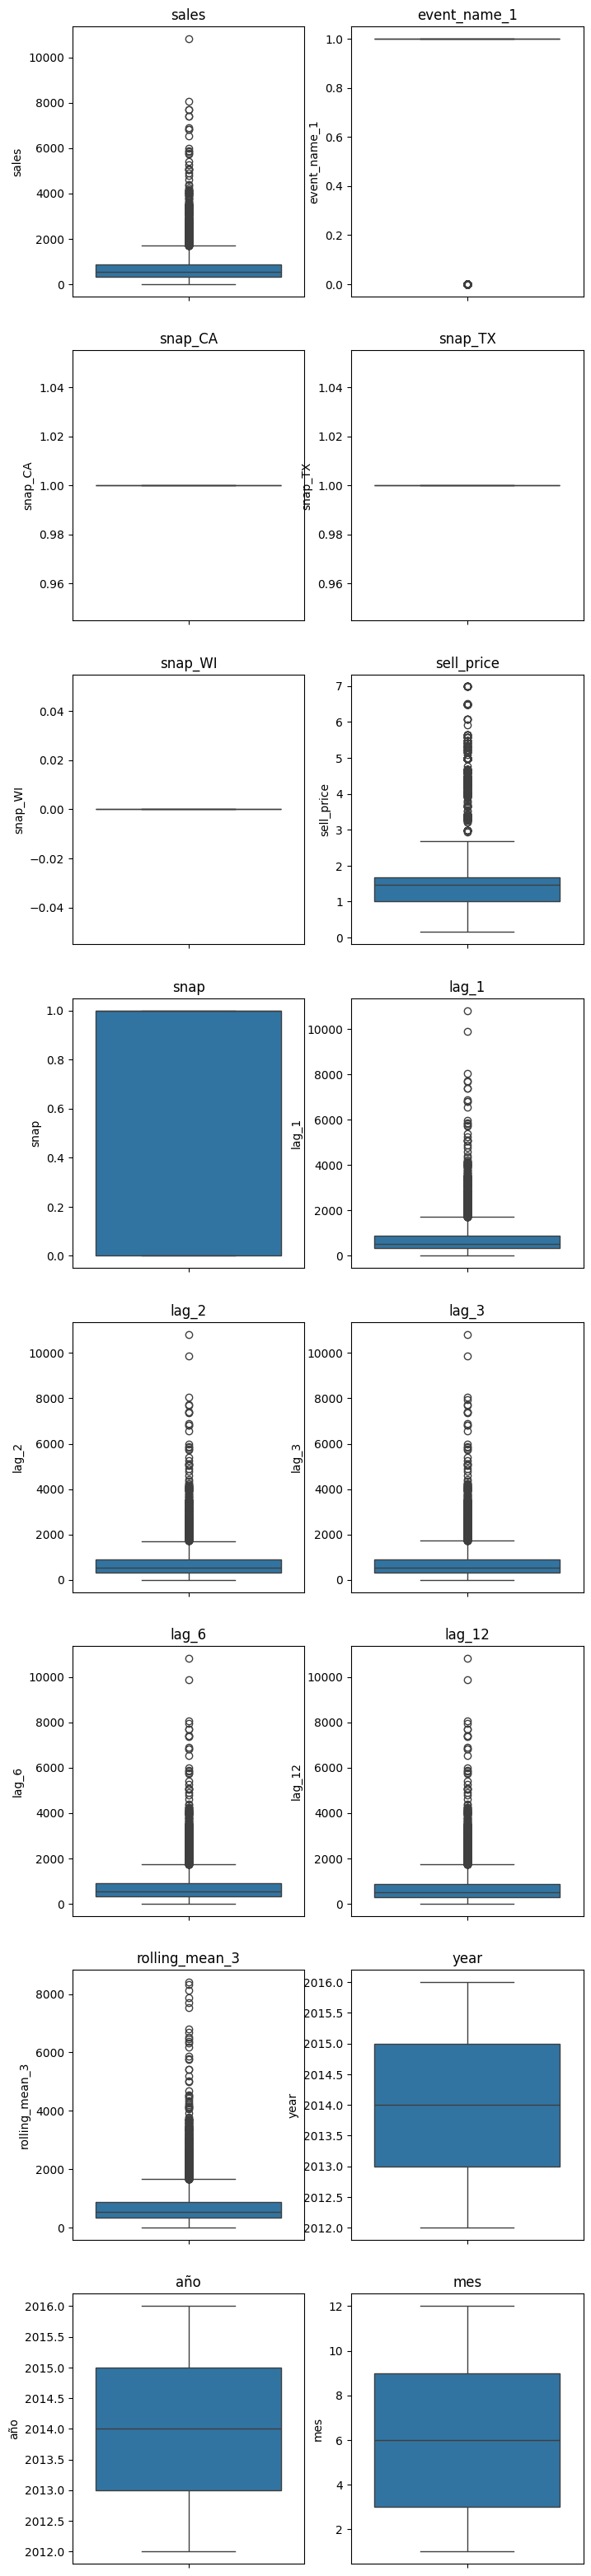

In [39]:
# Separar los gráficos en impares y pares
columns_odd = [col for i, col in enumerate(columns_number) if i % 2 != 0]  # Gráficos con índice impar (1, 3, 5,...)
columns_even = [col for i, col in enumerate(columns_number) if i % 2 == 0]  # Gráficos con índice par (0, 2, 4,...)

# Número de filas necesarias (igual a la cantidad máxima de gráficos en ambos grupos)
num_rows = max(len(columns_odd), len(columns_even))

# Crear la figura y los subgráficos
fig, axis = plt.subplots(num_rows, 2, figsize=(8, 5*num_rows))

# Graficar los gráficos impares (a la izquierda)
for i, col in enumerate(columns_even):
    sns.boxplot(ax=axis[i, 0], data=data, y=col)
    axis[i, 0].set_title(col)

# Graficar los gráficos pares (a la derecha)
for i, col in enumerate(columns_odd):
    sns.boxplot(ax=axis[i, 1], data=data, y=col)
    axis[i, 1].set_title(col)

Pese a verse valores que parecen outliers, todos ellos se tratan de casos especiales, en los que no se debe de ajustar sus valores.

### 6.Segmentaciones relevantes

#### Ventas por tienda

<Axes: title={'center': 'Ventas totales por tienda'}, xlabel='store_id'>

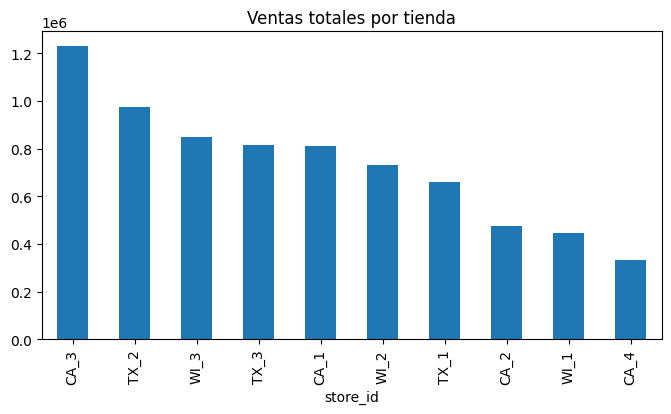

In [40]:
ventas_por_tienda = data.groupby('store_id')['sales'].sum().sort_values(ascending=False)
ventas_por_tienda.plot(kind='bar', title="Ventas totales por tienda", figsize=(8, 4))


Se observa que la tienda con mayores ventas es CA_3

#### Ventas por producto

<Axes: title={'center': 'Top 10 productos por ventas'}, xlabel='item_id'>

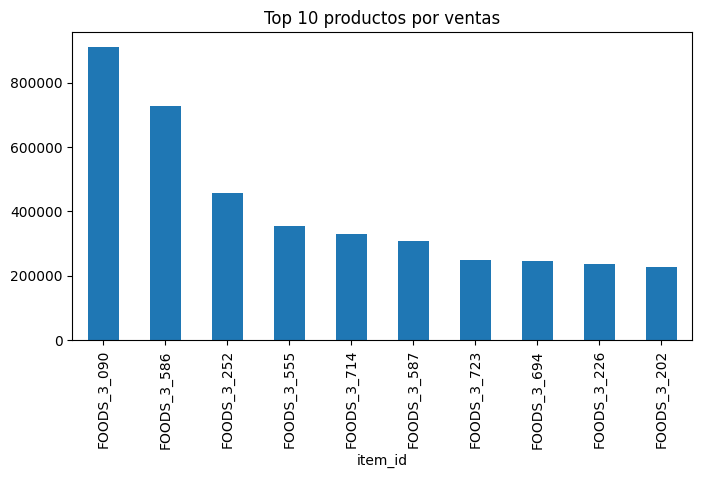

In [41]:
top_items = data.groupby('item_id')['sales'].sum().sort_values(ascending=False).head(10)
top_items.plot(kind='bar', title="Top 10 productos por ventas", figsize=(8, 4))


#### Ventas por evento

<Axes: title={'center': 'Ventas por tipo de evento'}, xlabel='event_name_1'>

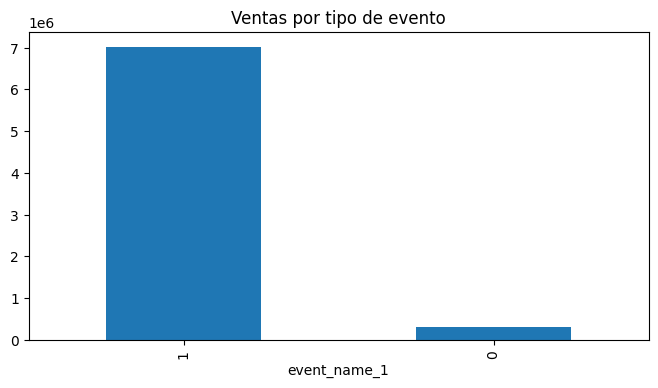

In [42]:
ventas_evento = data.groupby('event_name_1')['sales'].sum().sort_values(ascending=False)
ventas_evento.plot(kind='bar', title="Ventas por tipo de evento", figsize=(8, 4))
